# Convolution simulation of cellular automata

We saw in discrete simulations how algorithms can benefit from composing or grouping together many events instead of independently testing them. A similar issue often arises in discrete spatial models, like [cellular automata](https://en.wikipedia.org/wiki/Cellular_automaton). These models are a collection of cells which can take a discrete number of states, and whose dynamics are governed by a simple rulebook applied iteratively and (in principle) independently to each cell to determine its future state. 

In a nutshell, **cellular automata** can be summarized as spatial rulebooks. These rules take a defined local neighborhood (e.g. [Moore neighborhhod](https://en.wikipedia.org/wiki/Moore_neighborhood)), and assign a state for the center cell based on the states of others cells in the neighborhood. When the positions of cells matter, and since these states only take one of a few values (often 2 or 3), neighborhoods can be read as binary or ternary numbers respectively. The rulebook is then a dictionary taking a number representing the neighborhood as a key and returning the future state as value. When the position of cells do not matter, cellular automata are totalistic; meaning that the rulebook only needs the numbers of cells in a given state in the neighborhood. In this case, we can design our own encoding scheme to turn neighborhoods into numbers by assigning a given range of values to count a particular cells in a given state. We do a classic example next.

Regardless of the exact details, iterating the rulebook over every cell can be a slow process since every cell is looked at and counted multiple times for all neighborhoods to which it belongs. Thankfully, Fourier transform can come to the rescue, as they often do, through the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem). We can interpret the neighborhood definition as a kernel that we wish to convolve with the current state of the system. 

To understand the link between a cellular automaton and convolution, it is useful to imagine storing the state of the system in a [generating function](https://en.wikipedia.org/wiki/Generating_function) rather than an array. For a two dimensional system, imagine interpreting the $(i,j)$ entry of your array as the coefficient of the $x^iy^j$ term of two-dimensional polynomial. From there, one can also interpret the neighborhood function as the weight given to potential neighbors (e.g. $w_{tl}$ for the weight of the top-left neighbor) and the spatial relationship between neighbors (e.g., the top left neighbor needs to be multipled by $x$ and $y$ to affect its diagonal neighbor). The multiplication of the state polynomial and the neighborhood or kernel polynomial should then contain all important information about the state of every cell and of its neighborhood, which hopefully can then just be looked up in the rulebook. Below, we represent this multiplication with matrices to help visualize the connection with the spatial model, but these are actuall just classic polynomials missing their $+$ symbols. Here we go:


$$
S(x,y,t+1) = 
\textrm{Rulebook}\bigg\lbrace
\begin{pmatrix}
S_{11}xy & S_{21}x^2y & S_{31}x^3y & S_{41}x^4y \\
S_{12}x y^2 & S_{22}x^2y^2 & S_{32}x^3y^2 &S_{42} x^4y^2 \\
S_{13}x y^3 & S_{23}x^2y^3 & S_{33}x^3y^3 & S_{43}x^4y^3 \\
S_{14}x y^4 & S_{24}x^2y^4 & S_{34}x^3y^4 & S_{44}x^4y^4 \\
\end{pmatrix}
\times
\begin{pmatrix}
w_{tl}xy & w_{t}y & w_{tr}y/x \\
w_{l}x & w_{c} & w_{r}/x \\
w_{bl}x/y & w_{b}/y & w_{br}1/(xy) \\
\end{pmatrix}
\bigg\rbrace
$$

To see how this works, consider a simple binary cellular automaton where $S_{ij}$ equals 0 or 1, with a [von Neumann neighborhood](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood) such that $w_{tl}=w_{tr}=w_{bl}=w_{br}=0$. We can then set $w_t=1$, $w_r=2$, $w_b=4$, $w_l=8$, $w_c=16$ to interpret the result of the multiplication above as a binary number capturing the full state of every cell and neighborhood. For example, if we focus on cell $(2,2)$, the multiplication would give us $16S_{22}+8S_{12}+4S_{23}+2S_{32}+S_{21}$. This number will be in the interval (0,15) only if $S_{22}$ equals 0 and in the interval (16,31) otherwise. Then, the number will in the first half of that interval if the left neighbor $S_{12}$ equals 0 and in the second half otherwise. And so on for every neighbor of decreasing weight, until we know that the number will be odd if the state of top neighbor equals 1 and even otherwise. We can therefore encode the rulebook in a way that maps the result of this multiplication of this polynomial to the actual rule of the model!

Designing the kernel can be tricky but it is very valuable, especially if the neighborhood itself becomes large. Let's tackle a classic example!

## Conway's Game of Life

The [Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is a two-dimensional, binary, and totalistic, cellular automaton meant to represent a simple model of population dynamics. The totalistic rulebook consists of four rules:
* Live cells die in underdeveloped neighborhoods with fewer than two live neighbors.
* Live cells die in overpopulated neighborhoods with more than three live neighbors.
* Live cells in any other neighborhoods keep on living.
* Dead cells come back by reproduction only if they have exactly three live neighbors.

We first need to create a grid and assign the state 1 to any live cell and 0 to any dead cell. To apply the rulebook, we thus need to count live cells in our neighborhoods but also distinguish the state of the current cell. With a Moore neighborhood consisting of 8 neighbors, we can assign a weight of 1 to all neighbors such that the number of live neighbors will be between 0 and 8. We can then assign a weight of 10 to the center cell such that a dead cell with 5 live neighbors would correspond to rule 5 but a live cell with the same neighborhood would correspond to rule 15. Importantly, the rulebooks for dead and live cells do not overlap. The first covers rule 0 through 8 (potential numbers of live neighbors) and the other 10 through 18. This is simpler than a full encoding of the neighborhood as a binary number since we do not need to distinguish neighbors, only the central cell and its neighbors.

Here is a simple example implementing this smart rulebook-neighborhood pair as a kernel and using convolution to run the model.

<IPython.core.display.Javascript object>


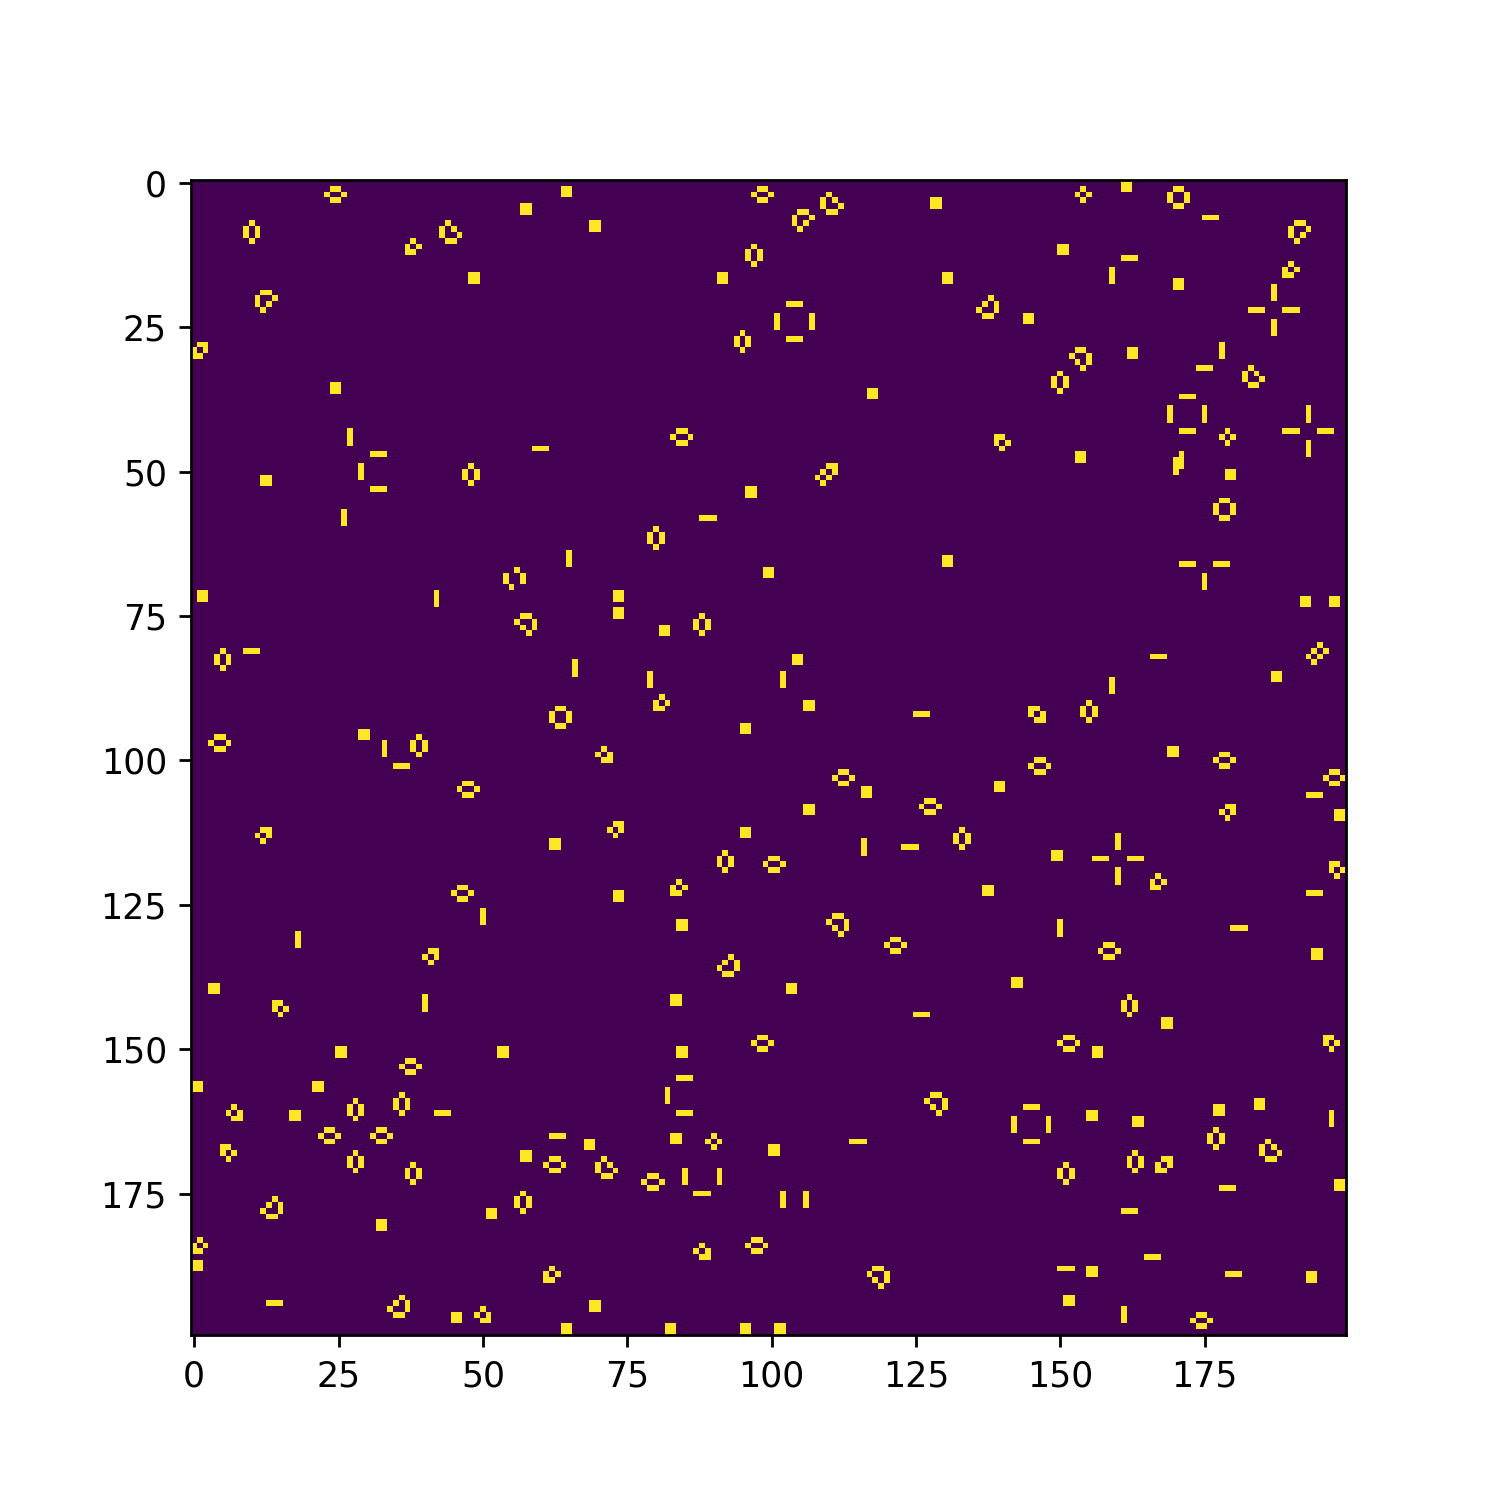

MovieWriter ffmpeg unavailable; using Pillow instead.


0.020129919052124023


In [85]:
%matplotlib notebook
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"

#random initial conditions
life = np.random.randint(2, size=(200, 200))

#kernel to sum 8 neighbors with center value counting center state
kernel = np.array([[1, 1, 1],
                   [1, 10, 1],
                   [1, 1, 1]])
#rulebook based on number of active neighbors and center state
table = np.zeros(20, dtype=np.uint8)
table[[3, 12, 13]] = 1

#initialize figure
fig, ax= plt.subplots(figsize=(6,6))
im = ax.imshow(life)

#animation function
def animate(i):
    life=im.get_array()
    #We use fixed boundary conditions with dead cells beyond our space
    #mode='wrap' would consider periodic boundary conditions
    life = convolve(life, kernel, mode='constant', cval=0)
    im.set_array(table[life])
    return [im]

#animation details
fps = 30
anim = FuncAnimation(fig,animate,frames=10*fps,interval=1000/fps)
anim.save('gol.gif', dpi=90)


![GameOfLife](./gol.gif)